In [1]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Flatten, Dense, Reshape, BatchNormalization, Activation, MaxPooling2D
import numpy as np
import json
from scipy.ndimage import imread
from scipy.misc import imresize
from skimage import color
import random
import os
from nbutil import imshow_multi
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


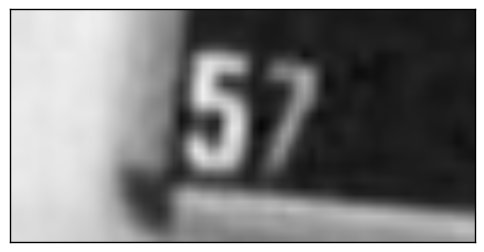

[ 5  7 10 10 10]
(32, 64)


In [2]:
NUM_OUTPUT_DIGITS = 5

class Dataset(object):
    def __init__(self, name):
        dir = '../data/svhn/' + name
        
        filename_labels = json.load(open(os.path.join(dir, 'labels.json')))
        filenames = filename_labels.keys()
        max_len = NUM_OUTPUT_DIGITS
        label_matrix = np.zeros((len(filenames), max_len), dtype=int)
        label_matrix.fill(10)
        for i, filename in enumerate(filenames):
            digits = '0123456789'
            for j, digit in enumerate(filename_labels[filename]):
                if j < NUM_OUTPUT_DIGITS:
                    label_matrix[i, j] = digits.index(digit)
        
        self.label_matrix = label_matrix
        self.filenames = filenames
        self.dir = dir
    
    def rand_pair(self):
        i = random.randint(0, len(self.filenames)-1)
        filename = os.path.join(self.dir, self.filenames[i])
        img = imread(filename)
        img = color.rgb2gray(img)
        img = imresize(img, [32, 64])
        return img / 255.0, self.label_matrix[i]
    
    def rand_batch(self, size=16):
        images = []
        labels = []
        for _ in xrange(size):
            img, label = self.rand_pair()
            images.append(img)
            # labels.append(self.flat_one_hot(label))
            labels.append(label)
        return np.array(images), np.array(labels)
    
    def generator(self, batch_size=8):
        def gen():
            while True:
                imgs, labels = self.rand_batch()
                yield np.expand_dims(imgs, -1), np.expand_dims(labels, -1)
        return gen()
    
    def flat_one_hot(self, label):
        x = np.zeros((NUM_OUTPUT_DIGITS, 11), dtype=int)
        for place, val in enumerate(label):
            x[place][val] = 1
        return x.reshape(NUM_OUTPUT_DIGITS * 11)

d = Dataset('train')
# print d.rand_pair()
img, label = d.rand_pair()
imshow_multi([img])
print label
print img.shape


In [17]:
model = Sequential()

"""
32 x 64 x 3
16 x 32 x 32
8 x 16 x 64
4 x 8 x 128
2 x 4 x 256
1 x 2 x 512
1024
512
70
10 x 7
"""

for i in xrange(5):
    channels = 16 * (2 ** i)
    kwargs = {}
    if i == 0:
        kwargs['input_shape'] = [32, 64, 1]
    model.add(Convolution2D(channels, 5, 5, activation='relu', border_mode='same', **kwargs))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(NUM_OUTPUT_DIGITS * 11))
model.add(Reshape((NUM_OUTPUT_DIGITS, 11)))
model.add(Activation('softmax'))
# model.add(Reshape([NUM_OUTPUT_DIGITS * 11]))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_11 (Convolution2D) (None, 32, 64, 16)    416         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 32, 64, 16)    64          convolution2d_11[0][0]           
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 16, 32, 16)    0           batchnormalization_6[0][0]       
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 16, 32, 16)    0           maxpooling2d_6[0][0]             
___________________________________________________________________________________________

In [33]:
model.fit_generator(d.generator(), 4096, 100, verbose=2)

Epoch 1/100
5s - loss: 1.1899 - acc: 0.6203
Epoch 2/100
5s - loss: 1.1806 - acc: 0.6226
Epoch 3/100
5s - loss: 1.1878 - acc: 0.6220
Epoch 4/100
5s - loss: 1.1759 - acc: 0.6271
Epoch 5/100
5s - loss: 1.1815 - acc: 0.6235
Epoch 6/100
5s - loss: 1.1848 - acc: 0.6176
Epoch 7/100
5s - loss: 1.1817 - acc: 0.6254
Epoch 8/100
5s - loss: 1.1714 - acc: 0.6240
Epoch 9/100
5s - loss: 1.1817 - acc: 0.6201
Epoch 10/100
5s - loss: 1.1785 - acc: 0.6225
Epoch 11/100
5s - loss: 1.1795 - acc: 0.6245
Epoch 12/100
5s - loss: 1.1699 - acc: 0.6277
Epoch 13/100
5s - loss: 1.1916 - acc: 0.6230
Epoch 14/100
5s - loss: 1.1560 - acc: 0.6308
Epoch 15/100
5s - loss: 1.1677 - acc: 0.6277
Epoch 16/100
5s - loss: 1.1663 - acc: 0.6290
Epoch 17/100
5s - loss: 1.1768 - acc: 0.6228
Epoch 18/100
5s - loss: 1.1693 - acc: 0.6280
Epoch 19/100
5s - loss: 1.1659 - acc: 0.6285
Epoch 20/100
5s - loss: 1.1661 - acc: 0.6269
Epoch 21/100
5s - loss: 1.1653 - acc: 0.6309
Epoch 22/100
5s - loss: 1.1645 - acc: 0.6298
Epoch 23/100
5s - l

KeyboardInterrupt: 

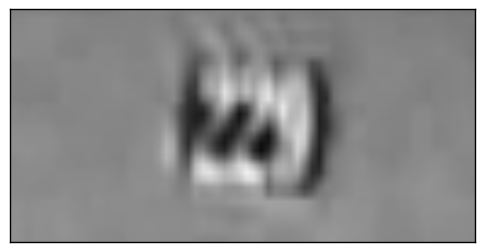

[ 2  1 10 10 10]


In [68]:

img, label = d.rand_pair()
img_batch = np.expand_dims(np.expand_dims(img, 0), -1)
pred = model.predict(img_batch).argmax(axis=-1)
imshow_multi([img])
print pred[0]
